# Replication of paper "Approximate Bayesian computational methods" (2011)

In [2]:
using Distributions, StatsPlots, Plots, StatsBase, LinearAlgebra, KernelDensity
using LaTeXStrings
using ProgressMeter
pyplot()

Plots.PyPlotBackend()

### **Alorithm 1** - Likelihood-free rejection sampler 1
Let's use sampling from Uniform with binomial likelihood function to illustrate this algorithm.

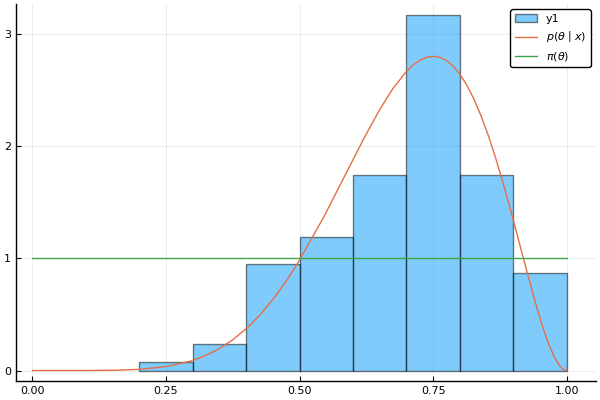

In [3]:
n, x = 8, 6
N = 1000

# Sample θ' from prior π(θ)
# Generate z from p(.|θ')
theta_s = rand(Beta(1,1),N)
z       = rand.(Binomial.(n,theta_s))
theta_a = theta_s[z .== x];
v = collect(range(0, stop=1, length=N));

histogram(theta_a,normalize=true,alpha=0.5)
plot!(Beta(x+1,n-x+1),label=L"p(\theta \mid x)")
plot!(Beta(1,1), label =L"\pi(\theta)")

### **Alorithm 2** - Likelihood-free rejection sampler 2

Let's write the functions for calculating the distances between the variables.

##### a) **Moving Average Model** - MA(2)

In [4]:
MA(current, u,t) = u[current+2] + u[current + 1] * t[1] + u[current] * t[2]

function genMA(u,t,n,N)
    z = zeros(N,n)
        for i=1:N
            z[i,:] = MA.((1:n),Ref(u[i,:]),Ref(t[i,:]))
        end
    return z
end

genMA (generic function with 1 method)

##### b) **Synthetic Dataset**
###### Moving Average model (MA)
$y_k = u_k + \sum_{i=1}^q \theta_i u_{k-i}$

$y \sim MA(q)$

$(\theta_1,\theta_2) =(0.6,0.2)$,sample size of 100.

In [5]:
using Random
Random.seed!(3)
theta = [0.6;0.2]
n     = 100
u     = randn(n+2)
y     = MA.((1:n),Ref(u),Ref(theta));

##### c) **Distance Functions and Suffient Statistics**

In [124]:
raw_distance(y,z)         = sqrt(sum((y-z).^2))
function abcautocov_distance(y,z)
    ay = 0
    az = 0
    for i = 2:length(y)
        ay +=y[i]*y[i-1]
        az +=z[i]*z[i-1]
    end
    ay2 = 0
    az2 = 0
    for i = 3:length(y)
        ay2 +=y[i]*y[i-2]
        az2 +=z[i]*z[i-2]
    end
    rho = (ay - az)^2+(ay2 - az2)^2 +(sum(y.^2)- sum(z.^2))^2 # Codigo com lag = 0 apresentou melhor resultado aparentemente
#     rho = (ay - az)^2+(ay2 - az2)^2
    return rho
end

function autocov_dist2(y,z)
    return sum((autocov(y)[2:3]-autocov(z)[2:3]).^2)*length(y)*length(z)
end

autocov_dist2 (generic function with 1 method)

Utilizando covarianca com lags 0,

##### d) **Triangular Sampling**
Using rejection sampling to sample uniformly in a triangle

In [125]:
function rand_TriUniform(N=1)
    trisample = zeros(N,2)
    count = 0
    while count < N
        theta = [4*rand()-2;2*rand()-1]
        if (theta[1]>-2 && theta[1]<2) && (sum(theta)>-1) && (theta[1]-theta[2] < 1)
            count+=1
            trisample[count,:] = theta
        end
    end
    return trisample
end

rand_TriUniform (generic function with 2 methods)

##### e) **Running Algorithm 2**

In [126]:
# Random.seed!(1)
N = 10^6        # number of trials
n = length(y) # sample size
theta_s = rand_TriUniform(N)
u       = randn(N,n+2)
z       = genMA(u,theta_s,n,N);

In [127]:
autocov_vectorize(z)    = abcautocov_distance(y,z)
dist_vectorize(z)       = raw_distance(y,z)
rho_autocov = mapslices(autocov_vectorize, z, dims =2)[:];
rho_dist    = mapslices(dist_vectorize, z, dims =2)[:];

epsilon10e4_autocov = quantile(rho_autocov,0.1/100)
epsilon10e4_dist    = quantile(rho_dist,0.1/100)

theta_ac_auto = theta_s[rho_autocov .< epsilon10e4_autocov,:];
theta_ac_dist = theta_s[rho_dist    .< epsilon10e4_dist,:];

z_ac_auto = z[rho_autocov .< epsilon10e4_autocov,:];
epsilon10e4_autocov

90.29942525329108

In [128]:
function Ger_Simga(θ1,θ2, y)
    Σ = zeros(100,100)
    for i=1:length(y)
        if i == 1
            Σ[i,i]   = 1 + θ1^2 + θ2^2
            Σ[i,i+1] = θ1 + θ1*θ2
            Σ[i,i+2] = θ2
        elseif i == 2
            Σ[i,i-1] = θ1 + θ1*θ2
            Σ[i,i]   = 1 + θ1^2 + θ2^2
            Σ[i,i+1] = θ1 + θ1*θ2
            Σ[i,i+2] = θ2
        elseif i == 99
            Σ[i,i-2] = θ2
            Σ[i,i-1] = θ1 + θ1*θ2
            Σ[i,i]   = 1 + θ1^2 + θ2^2
            Σ[i,i+1] = θ1 + θ1*θ2
        elseif i == 100
            Σ[i,i-2] = θ2
            Σ[i,i-1] = θ1 + θ1*θ2
            Σ[i,i]   = 1 + θ1^2 + θ2^2
        else
            Σ[i,i-2] = θ2
            Σ[i,i-1] = θ1 + θ1*θ2
            Σ[i,i]   = 1 + θ1^2 + θ2^2
            Σ[i,i+1] = θ1 + θ1*θ2
            Σ[i,i+2] = θ2
        end
    end

    return Σ
end

Ger_Simga (generic function with 1 method)

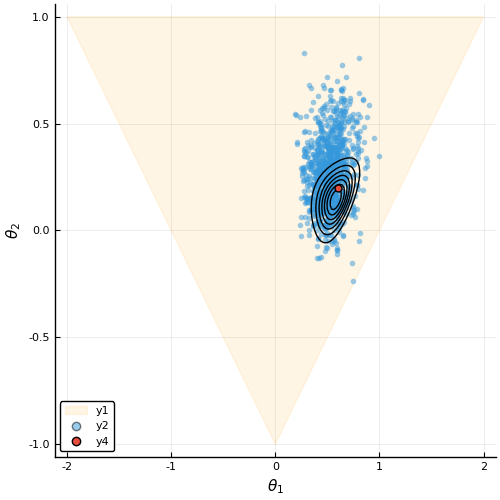

In [129]:
plot(Plots.P2[(0,-1),(-2,1),(2,1),(0,-1)],fill=true,color=:orange,alpha=0.1)
scatter!(theta_ac_auto[:,1],theta_ac_auto[:,2],xlims=[-2,2],alpha=0.5,markerstrokewidth=0,c="#3498db")


# Contour Plot - True posterior
gθ1      = -0:0.02:1
gθ2      = -0.5:0.02:0.5
gridθ1   = repeat(reshape(gθ1, 1, :), length(gθ2), 1)
gridθ2   = repeat(gθ2, 1, length(gθ1))
mamvn(θ1,θ2) = pdf(MvNormal(zeros(100),Ger_Simga(θ1,θ2,y)),y)
Z = map(mamvn, gridθ1, gridθ2)
p1 = contour!(gθ1,gθ2, mamvn, fill=false,c=:black,levels=8,
    xlabel=L"\theta_1", ylabel=L"\theta_2",colorbar=false)

scatter!([theta[1]],[theta[2]],markersize=5,c="#e74c3c",size=(500,500))

### **Metropolis-Hasting Estimating Marginal**

In [12]:
# M-H
x1 = rand()
x2 = rand() - 0.5
burnin = 1_000
steps = 100_000
C = zeros(steps,2)
Xprevious   = [0;0]

p = Progress(steps)
for i=1:steps
    Xnew        = Xprevious + randn(2)*0.1
    alpha = minimum([1,exp(log(mamvn(Xnew[1],Xnew[2])) - log(mamvn(Xprevious[1],Xprevious[2])))])
#     println(1 - alpha, Xnew)
    if rand() < (1 - alpha) # Reject
        Xnew = Xprevious
    end
    C[i,:] = Xnew
    Xprevious = Xnew
    next!(p)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48:42


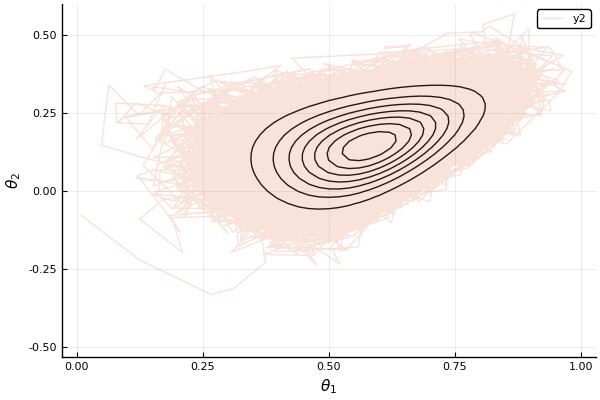

In [13]:
contour(gθ1,gθ2, mamvn, fill=false,c=:black,levels=8,
    xlabel=L"\theta_1", ylabel=L"\theta_2",colorbar=false)
plot!(C[:,1],C[:,2],alpha=0.2)

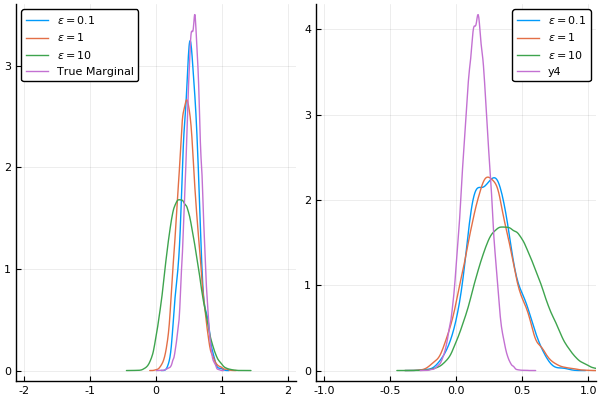

In [130]:
epsilon10e4_autocov = quantile(rho_autocov,0.1/100)
epsilon10e4_dist    = quantile(rho_dist,0.1/100)
theta_ac_auto = theta_s[rho_autocov .< epsilon10e4_autocov,:];
theta_ac_dist = theta_s[rho_dist    .< epsilon10e4_dist,:];

epsilon10e3_autocov = quantile(rho_autocov,1/100)
epsilon10e3_dist    = quantile(rho_dist,1/100)
theta_ac_auto10e3 = theta_s[rho_autocov .< epsilon10e3_autocov,:];
theta_ac_dist10e3 = theta_s[rho_dist    .< epsilon10e3_dist,:];

epsilon10e2_autocov = quantile(rho_autocov,10/100)
epsilon10e2_dist    = quantile(rho_dist,10/100)
theta_ac_auto10e2 = theta_s[rho_autocov .< epsilon10e2_autocov,:];
theta_ac_dist10e2 = theta_s[rho_dist    .< epsilon10e2_dist,:];


MH = C[1_000:end,:]

θ1_marginal =  MH[:,1]
θ2_marginal =  MH[:,2]
h1 = density(theta_ac_auto[:,1],normalize=true,xlims=[-2,2],label=L"\epsilon=0.1%")
density!(theta_ac_auto10e3[:,1],normalize=true,xlims=[-2,2],label=L"\epsilon=1%")
density!(theta_ac_auto10e2[:,1],normalize=true,xlims=[-2,2],label=L"\epsilon=10%")
d1 = density!(θ1_marginal,label="True Marginal")
h2 = density(theta_ac_auto[:,2],normalize=true,xlims=[-1,1],label=L"\epsilon=0.1%")
density!(theta_ac_auto10e3[:,2],normalize=true,xlims=[-1,1],label=L"\epsilon=1%")
density!(theta_ac_auto10e2[:,1],normalize=true,xlims=[-1,1],label=L"\epsilon=10%")
d2 = density!(θ2_marginal)
plot(d1,d2,layout=2)

#### Comparing the Distance Metrics

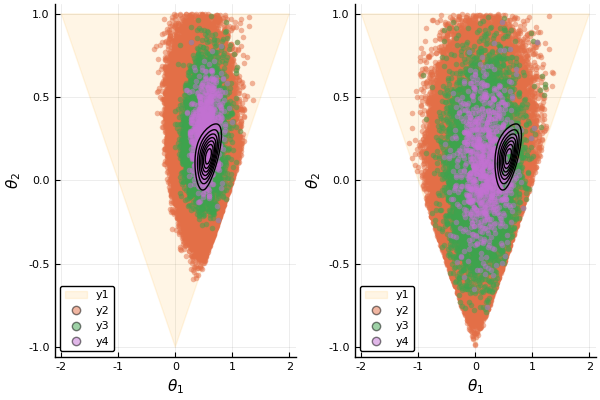

In [131]:
plot(Plots.P2[(0,-1),(-2,1),(2,1),(0,-1)],fill=true,color=:orange,alpha=0.1)
scatter!(theta_ac_auto10e2[:,1],theta_ac_auto10e2[:,2],xlims=[-2,2],alpha=0.5,markerstrokewidth=0)
scatter!(theta_ac_auto10e3[:,1],theta_ac_auto10e3[:,2],xlims=[-2,2],alpha=0.5,markerstrokewidth=0)
scatter!(theta_ac_auto[:,1],theta_ac_auto[:,2],xlims=[-2,2],alpha=0.5,markerstrokewidth=0)
p1 = contour!(gθ1,gθ2, mamvn, fill=false,c=:black,levels=8,
    xlabel=L"\theta_1", ylabel=L"\theta_2",colorbar=false)

plot(Plots.P2[(0,-1),(-2,1),(2,1),(0,-1)],fill=true,color=:orange,alpha=0.1)
scatter!(theta_ac_dist10e2[:,1],theta_ac_dist10e2[:,2],xlims=[-2,2],alpha=0.5,markerstrokewidth=0)
scatter!(theta_ac_dist10e3[:,1],theta_ac_dist10e3[:,2],xlims=[-2,2],alpha=0.5,markerstrokewidth=0)
scatter!(theta_ac_dist[:,1],theta_ac_dist[:,2],xlims=[-2,2],alpha=0.5,markerstrokewidth=0)
p2 = contour!(gθ1,gθ2, mamvn, fill=false,c=:black,levels=8,
    xlabel=L"\theta_1", ylabel=L"\theta_2",colorbar=false)
plot(p1,p2,layout=2)

### **Alorithm 3** - MCMC-ABC

In [132]:
# Step 1 - Initialisation of the MCMC sampler
N = 10^3        # number of trials
n = length(y) # sample size
theta_s = rand_TriUniform(N)
u       = randn(N,n+2)
zmcmc       = genMA(u,theta_s,n,N);
rho_autocov = mapslices(autocov_vectorize, zmcmc, dims =2)[:];
epsilon10e4_autocov = quantile(rho_autocov,0.1/100)
theta_init = theta_s[rho_autocov .< epsilon10e4_autocov,:][:];

**ATTENTION**

There was a mistake in the implementation of the ABC-MCMC, now it is correct.

In [204]:
N     = (10^6)*5
theta_mcmc = theta_init'
theta_now  = theta_init
epsilon = epsilon10e4_autocov*0.05
# push!(theta_mcmc,theta_init)
p = Progress(N)
for i=1:N
    theta_new = rand(MvNormal(theta_now,[1. 0.;0. 1.].*0.1))
    u         = randn(n+2) 
    z_new     = MA.((1:n),Ref(u),Ref(theta_new))
    if (theta_new[1]>-2 && theta_new[1]<2) && (sum(theta_new)>-1) && (theta_new[1]-theta_new[2] < 1) && (theta_new[2]<1)
        alpha = 1
    else
        alpha = 0
    end
    if (rand() <= alpha) && (abcautocov_distance(y,z_new) <= epsilon)
        theta_now = theta_new
        theta_mcmc= vcat(theta_mcmc,theta_now')
    end
    next!(p)
end
# theta_mcmc = theta_mcmc'
print(length(theta_mcmc[:,1]))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:27


242

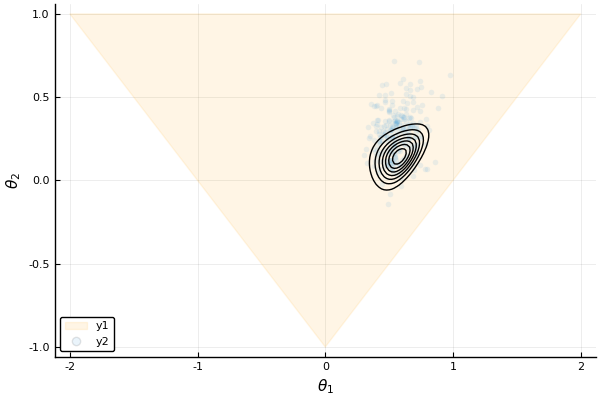

In [205]:
plot(Plots.P2[(0,-1),(-2,1),(2,1),(0,-1)],fill=true,color=:orange,alpha=0.1)
scatter!(theta_mcmc[:,1],theta_mcmc[:,2],xlims=[-2,2],alpha=0.1,markerstrokewidth=0,c="#3498db")
contour!(gθ1,gθ2, mamvn, fill=false,c=:black,levels=8,
    xlabel=L"\theta_1", ylabel=L"\theta_2",colorbar=false)

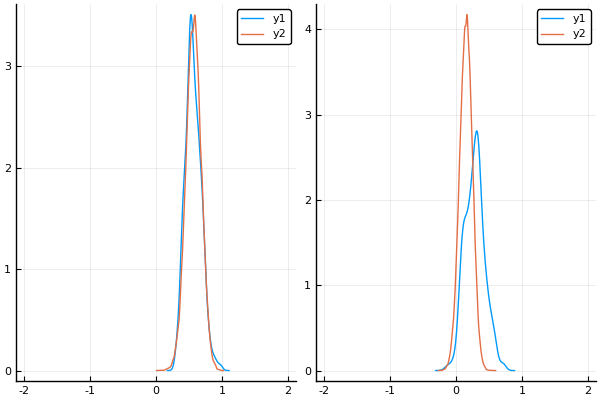

In [206]:
density(theta_mcmc[:,1],normalize=true,xlims=[-2,2])
d1 = density!(θ1_marginal)
density(theta_mcmc[:,2],normalize=true,xlims=[-2,2])
d2 = density!(θ2_marginal)
plot(d1,d2,layout=2)

### **Alorithm 4** - ABC-PMC

In [187]:
Np = 10_000
epsilons = epsilon10e4_autocov.*collect(10:-1:1)*0.5;
T = length(epsilons)

θpmc = zeros(1,2)
for i = 1:Np
    θi = rand_TriUniform(1)
    u         = randn(n+2) 
    z_new     = MA.((1:n),Ref(u),Ref(θi))
    while abcautocov_distance(y,z_new) > epsilons[1]
        θi = rand_TriUniform(1)
        u         = randn(n+2) 
        z_new     = MA.((1:n),Ref(u),Ref(θi))
    end
    θpmc = vcat(θpmc, θi)
end

θpmc = [θpmc[2:end,:]]
w   = [Weights(1/Np .* ones(Np))];
for i = 2:T
    w = vcat(w,[Weights(1/Np .* zeros(Np))])
    θpmc = vcat(θpmc, [zeros(Np,2)])
end

Σemp = [var(θpmc[1][:,1],w[1],corrected=false),
    var(θpmc[1][:,2],w[1],corrected=false)].*2

ϕabcpmc(θ) = pdf(MvNormal(zeros(2),1),θ)
for t = 2:T
    p = Progress(Np)
    for i= 1:Np
        safe = 0
        ρ = epsilons[t]+1
        θnew = zeros(1,2)
        while (ρ > epsilons[t]) && (safe < 10000)
            safe +=1
            θst  = [sample(θpmc[t-1][:,1],w[t-1]),sample(θpmc[t-1][:,2],w[t-1])]
            θnew = rand(MvNormal(θst,sqrt.(Σemp)))
            if (θnew[1]>-2 && θnew[1]<2) && (sum(θnew)>-1) && (θnew[1]-θnew[2] < 1) && (θnew[2]<1)
                u         = randn(n+2) 
                z_new     = MA.((1:n),Ref(u),Ref(θnew))
                ρ    = abcautocov_distance(y,z_new)
            else
                ρ = epsilons[t]+1
            end
        end
        if safe >= 10000
            println(ρ," ",epsilons[t])
            println("unsafe")
        end
        θpmc[t][i,:] = θnew
        if θnew[1]> 2
            print(θnew)
        end
        δθ = θpmc[t][i,:]'.-θpmc[t-1]
        w[t][i] = (1/4.0) / sum(w[t-1].*ϕabcpmc(δθ[:,1:end]'))
    next!(p)
    end
    Σemp = [var(θpmc[t][:,1],w[t],corrected=false),
        var(θpmc[t][:,2],w[t],corrected=false)].*2
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:11
Progress: 100%|█████████████████████████████████████████| Time: 0:00:11
Progress: 100%|█████████████████████████████████████████| Time: 0:00:13
Progress: 100%|█████████████████████████████████████████| Time: 0:00:15
Progress: 100%|█████████████████████████████████████████| Time: 0:00:17
Progress: 100%|█████████████████████████████████████████| Time: 0:00:22
Progress: 100%|█████████████████████████████████████████| Time: 0:00:32
Progress: 100%|█████████████████████████████████████████| Time: 0:00:59
Progress: 100%|█████████████████████████████████████████| Time: 0:02:31


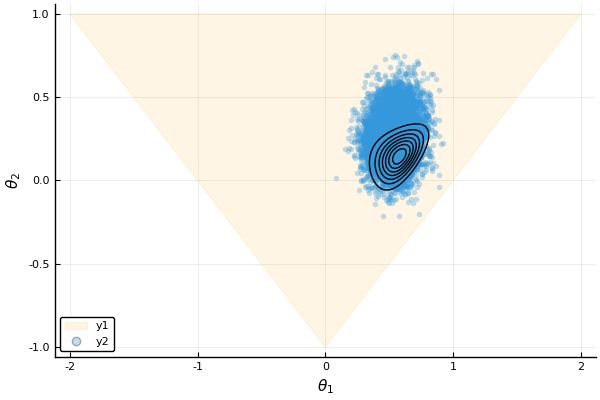

In [189]:
plot(Plots.P2[(0,-1),(-2,1),(2,1),(0,-1)],fill=true,color=:orange,alpha=0.1)
scatter!(θpmc[end][:,1],θpmc[end][:,2],alpha=0.3,markerstrokewidth=0,c="#3498db")
contour!(gθ1,gθ2, mamvn, fill=false,c=:black,levels=8,
    xlabel=L"\theta_1", ylabel=L"\theta_2",colorbar=false)

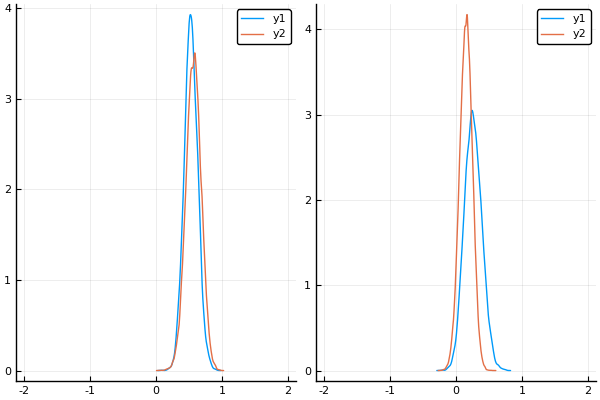

In [190]:
density(θpmc[end][:,1],normalize=true,xlims=[-2,2])
d1 = density!(θ1_marginal)
density(θpmc[end][:,2],normalize=true,xlims=[-2,2])
d2 = density!(θ2_marginal)
plot(d1,d2,layout=2)

## **Post-Processing ABC**

In [148]:
# Random.seed!(1)
N = 10^6        # number of trials
n = length(y) # sample size
theta_s = rand_TriUniform(N)
u       = randn(N,n+2)
z       = genMA(u,theta_s,n,N);

rho_autocov = mapslices(autocov_vectorize, z, dims =2)[:];
epsilon10e4_autocov = quantile(rho_autocov,0.1/100)
theta_ac_auto = theta_s[rho_autocov .< epsilon10e4_autocov,:];
epsilon10e3_autocov = quantile(rho_autocov,1/100)
theta_ac_auto10e3 = theta_s[rho_autocov .< epsilon10e3_autocov,:];
epsilon10e2_autocov = quantile(rho_autocov,10/100)
theta_ac_auto10e2 = theta_s[rho_autocov .< epsilon10e2_autocov,:];

In [149]:
function error_autocov(y,z)
    ay = 0
    az = 0
    for i = 2:length(y)
        ay +=y[i]*y[i-1]
        az +=z[i]*z[i-1]
    end
    ay2 = 0
    az2 = 0
    for i = 3:length(y)
        ay2 +=y[i]*y[i-2]
        az2 +=z[i]*z[i-2]
    end
    rho = [(ay - az);(ay2 - az2)]
    return rho
end
error_autocov_vectorize(z)    = error_autocov(y,z)
e_autocov = mapslices(error_autocov_vectorize, z, dims =2);

In [150]:
theta_ac_auto10e2
epsilon10e4_autocov
rho_10e2 = rho_autocov[rho_autocov .< epsilon10e2_autocov,:];
e_autocov10e2 = e_autocov[rho_autocov .< epsilon10e2_autocov,:];
e_autocov10e4 = e_autocov[rho_autocov .< epsilon10e4_autocov,:];

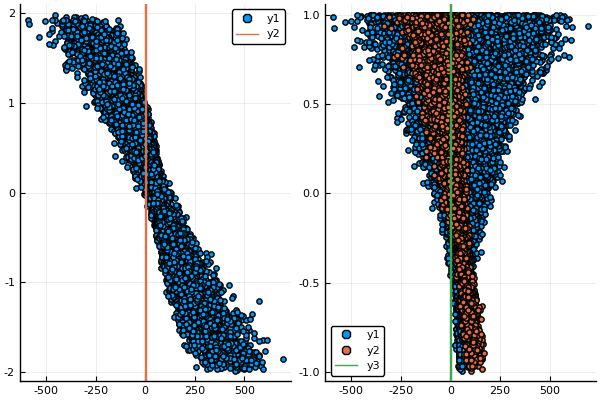

In [151]:
p1 = scatter(e_autocov[1:20_000,1],theta_s[1:20_000,1],marker=:o)
# p1 = scatter!(e_autocov[1:10_000,2],theta_s[1:10_000,1],marker=:o)
p1 = vline!([0,2])
p2 = scatter(e_autocov[1:20_000,1],theta_s[1:20_000,2],marker=:o)
p2 = scatter!(e_autocov[1:20_000,2],theta_s[1:20_000,2],marker=:o)
p2 = vline!([0,2])
plot(p1,p2, layout=2)

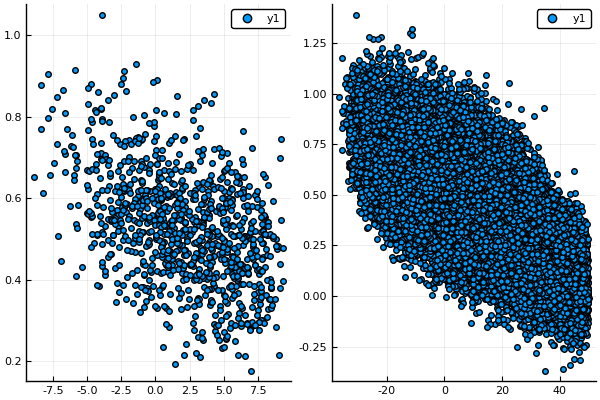

In [152]:
p1 = scatter(e_autocov10e4[:,1],theta_ac_auto[:,1],)
# p1 = scatter!(e_autocov10e4[:,2],theta_ac_auto[:,2],)
p2 = scatter(e_autocov10e2[:,1],theta_ac_auto10e2[:,1],)
# p2 = scatter!(e_autocov10e2[:,2],theta_ac_auto10e2[:,2],)
plot(p1,p2,layout=2)

### Ajustar o cálculo dos pesos. Deve-se usar o Epanechnikov em $||s_i - s||$

In [153]:
σ10e2 = maximum(sqrt.(e_autocov10e2.^2))
plot(Epanechnikov(0,σ10e2))
W10e2 = pdf.(Epanechnikov(0,σ10e2),sqrt.(rho_10e2)[:])
W10e2s2 = pdf.(Epanechnikov(0,σ10e2),e_autocov10e2[:,2])
# W10e4 = [pdf.(Epanechnikov(0,σ10e4),e_autocov10e2[:,1]) pdf.(Epanechnikov(0,σ10e4),e_autocov10e2[:,2])]; #Weights

In [154]:
using LsqFit, GLM

In [155]:
m(t, p) = p[1].*t[:,1].+p[2]
model(t, p) = p[1].*t[:,1].+p[2].*t[:,2] .+ p[3]
p0 = [0.5, 0.1]
# fit = curve_fit(m, e_autocov10e2, theta_ac_auto10e2[:,1],W10e2,p0)
# fit.param
p1 = [0.5, 0.5, 0.1]
# fit = curve_fit(model, e_autocov10e2, theta_ac_auto10e2[:,1],p1)
fit_t1 = curve_fit(model, e_autocov10e2, theta_ac_auto10e2[:,1],W10e2,p1)
fit_t2 = curve_fit(model, e_autocov10e2, theta_ac_auto10e2[:,2],W10e2,p1)
# fit_s1 = curve_fit(model, e_autocov10e2, theta_ac_auto10e2[:,1],W10e2s2,p1)
fit_t1.param, fit_t2.param

([-0.00945372, 0.0042586, 0.505948], [0.000158745, -0.0103116, 0.282253])

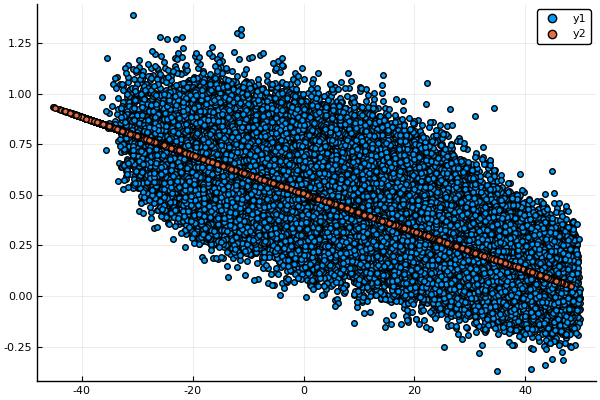

In [156]:
p2 = scatter(e_autocov10e2[:,1],theta_ac_auto10e2[:,1])
scatter!(e_autocov10e2[:,2],fit_t1.param[1].*e_autocov10e2[:,2].+fit_t1.param[3])

In [157]:
theta_r = hcat(theta_ac_auto10e2[:,1] - model(e_autocov10e2,fit_t1.param).+fit_t1.param[3],
    theta_ac_auto10e2[:,2] - model(e_autocov10e2,fit_t2.param).+fit_t2.param[3]);

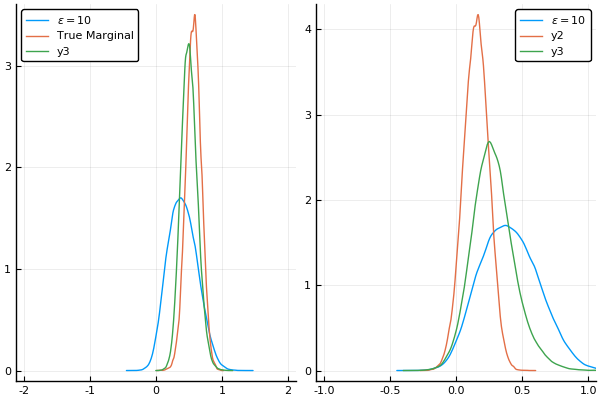

In [159]:
density(theta_ac_auto10e2[:,1],normalize=true,xlims=[-2,2],label=L"\epsilon=10%")
d1 = density!(θ1_marginal,label="True Marginal")
density!(theta_r[:,1],normalize=true)
density(theta_ac_auto10e2[:,1],normalize=true,xlims=[-1,1],label=L"\epsilon=10%")
d2 = density!(θ2_marginal)
density!(theta_r[:,2],normalize=true)
plot(d1,d2,layout=2)